In [ ]:
# Sentiment Analysis on Tweets
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk

In [ ]:
path = kagglehub.dataset_download("saurabhshahane/twitter-sentiment-dataset")
print("Path to dataset files:", path)
# Load and Inspect Data
df = pd.read_csv(path + "/Twitter_Data.csv")
print(df.head())
print(df.info())
print(df.describe())
# Check for missing values
print("Missing values:\n", df.isnull().sum())

Using Colab cache for faster access to the 'twitter-sentiment-dataset' dataset.
Path to dataset files: /kaggle/input/twitter-sentiment-dataset
                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB
None
            category
count  162973.000000
mean        0.225436
std         0.781279
min        -1.000000
25%         0.000000
50%         0.0000

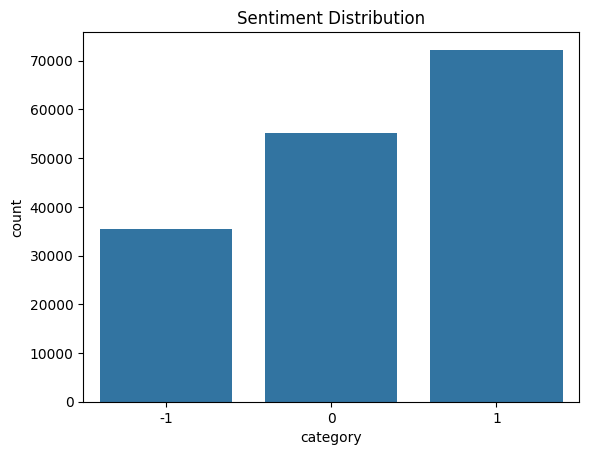

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                          clean_text  category
0  modi promis “minimum govern maximum governance...        -1
1               talk nonsens continu drama vote modi         0
2  say vote modi welcom bjp told rahul main campa...         1
3  ask support prefix chowkidar name modi great s...         1
4  answer among power world leader today trump pu...         1


In [ ]:
# EDA - Sentiment Distribution
# Drop rows with missing values in 'category' before plotting
df_cleaned = df.dropna(subset=['category']).copy()
df_cleaned['category'] = df_cleaned['category'].astype(int) # Convert category to int
sns.countplot(x='category', data=df_cleaned)
plt.title("Sentiment Distribution")
plt.show()
# Text Preprocessing Functions
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
def clean_text(text):
    # Ensure text is a string before applying regex
    text = str(text)
    # Remove URLs, mentions, hashtags, numbers, punctuation
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Lowercase
    text = text.lower()
    # Tokenization + stopword removal + stemming
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

    return " ".join(tokens)
# Apply cleaning
df_cleaned['clean_text'] = df_cleaned['clean_text'].astype(str).apply(lambda x: clean_text(x) if pd.notna(x) else "")
print(df_cleaned[['clean_text','category']].head())

Accuracy: 0.7365159231760446
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.91      0.42      0.57      7152
         0.0       0.88      0.66      0.76     11067
         1.0       0.65      0.95      0.77     14375

    accuracy                           0.74     32594
   macro avg       0.81      0.68      0.70     32594
weighted avg       0.79      0.74      0.72     32594



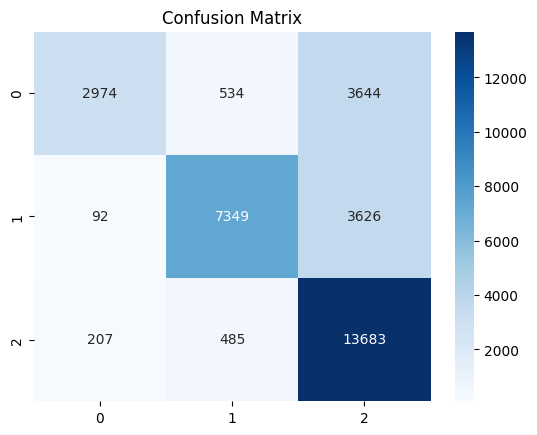

In [ ]:
# Drop rows with missing values in 'clean_text' or 'category' before splitting
df_processed = df.dropna(subset=['clean_text', 'category']).copy()
# Train-Test Split
X = df_processed['clean_text']
y = df_processed['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Build Pipeline (TF-IDF + Naive Bayes)
model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('nb', MultinomialNB())
])
# Train
model.fit(X_train, y_train)
# Predict
y_pred = model.predict(X_test)
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Sentiment Prediction Function
def predict_sentiment(text):
    clean = clean_text(text)
    prediction = model.predict([clean])[0]
    return prediction
# Test on Sample Tweets
sample_tweet1 = "I love this product, it is amazing!"
sample_tweet2 = "This is the worst service ever, totally disappointed."
print("Tweet:", sample_tweet1, "=> Sentiment:", predict_sentiment(sample_tweet1))
print("Tweet:", sample_tweet2, "=> Sentiment:", predict_sentiment(sample_tweet2))

Tweet: I love this product, it is amazing! => Sentiment: 1.0
Tweet: This is the worst service ever, totally disappointed. => Sentiment: -1.0
